In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  5 04:23:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install pydicom
!pip install pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 손실 함수 정의
def mle_loss(E_psi, E_phi, z_x, z_y, z_yx_T, z_xy_T):
    L_YX = E_psi(z_x) - E_psi(z_yx_T)
    L_XY = E_phi(z_y) - E_phi(z_xy_T)
    return L_YX, L_XY

def consistency_loss(E_psi, E_phi, z_yx_T, z_xy_T):
    L1_YXY = E_psi(z_yx_T) - E_phi(z_yx_T)
    L2_YXY = E_phi(z_xy_T) - E_psi(z_xy_T)
    L_C = L1_YXY + L2_YXY
    return L_C

def total_loss(E_psi, E_phi, z_x, z_y, z_yx_T, z_xy_T, gamma=0.1):
    L_YX, L_XY = mle_loss(E_psi, E_phi, z_x, z_y, z_yx_T, z_xy_T)
    L_C = consistency_loss(E_psi, E_phi, z_yx_T, z_xy_T)
    total_loss = L_YX + L_XY + gamma * L_C
    return total_loss, L_YX, L_XY, L_C

# 학습 루프
def train_model(model, data_loader, optimizer, epochs=50, gamma=0.1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (source, target) in enumerate(data_loader):
            source, target = source.cuda(), target.cuda()

            # Forward pass
            z_x, z_y, z_yx_T, z_xy_T = model(source, target)

            # Loss calculations
            L_YX = model.E_psi(z_x).mean() - model.E_psi(z_yx_T).mean()
            L_XY = model.E_phi(z_y).mean() - model.E_phi(z_xy_T).mean()
            L_C1 = model.E_psi(z_yx_T).mean() - model.E_phi(z_yx_T).mean()
            L_C2 = model.E_phi(z_xy_T).mean() - model.E_psi(z_xy_T).mean()
            L_C = L_C1 + L_C2

            loss = L_YX + L_XY + gamma * L_C

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # 중간 결과 출력
            if batch_idx == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")

        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {epoch_loss:.4f}")

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dataset definition
class GlioblastomaMRIDataset(Dataset):
    def __init__(self, pre_dir, post_dir, transform=None):
        self.pre_dir = pre_dir
        self.post_dir = post_dir
        self.transform = transform
        self.pre_files = sorted(os.listdir(pre_dir))
        self.post_files = sorted(os.listdir(post_dir))

    def __len__(self):
        return len(self.pre_files)

    def __getitem__(self, idx):
        # Load DICOM files
        pre_path = os.path.join(self.pre_dir, self.pre_files[idx])
        post_path = os.path.join(self.post_dir, self.post_files[idx])
        pre_dicom = pydicom.dcmread(pre_path)
        post_dicom = pydicom.dcmread(post_path)

        # Normalize pixel arrays
        pre_image = pre_dicom.pixel_array.astype(np.float32)
        post_image = post_dicom.pixel_array.astype(np.float32)
        pre_image = (pre_image - pre_image.min()) / (pre_image.max() - pre_image.min())
        post_image = (post_image - post_image.min()) / (post_image.max() - post_image.min())

        # Resize and add channel dimension
        pre_image = cv2.resize(pre_image, (256, 256))
        post_image = cv2.resize(post_image, (256, 256))
        pre_image = np.expand_dims(pre_image, axis=0)
        post_image = np.expand_dims(post_image, axis=0)

        # Convert to tensor
        pre_image = torch.tensor(pre_image, dtype=torch.float32)
        post_image = torch.tensor(post_image, dtype=torch.float32)

        return pre_image, post_image

# Visualization function
def visualize_results(source, target, predicted_target):
    source = source.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    predicted_target = predicted_target.cpu().detach().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Source")
    plt.imshow(source[0, 0], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Target")
    plt.imshow(target[0, 0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Target")
    plt.imshow(predicted_target[0, 0], cmap='gray')
    plt.show()

# Encoder definition
class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()
        blocks = [
            nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, channel, 3, padding=1),
        ]
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)

# Updated Decoder definition
class Decoder(nn.Module):
    def __init__(self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()
        blocks = [
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel // 2, out_channel, 4, stride=2, padding=1),
        ]
        self.blocks = nn.Sequential(*blocks)
        self.final_upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)  # Resize to 256x256

    def forward(self, x):
        x = self.blocks(x)
        x = self.final_upsample(x)
        return x

# Model definition
class CCTEBMModel(nn.Module):
    def __init__(self, encoder, decoder, input_dim, latent_dim=128):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fc = nn.Linear(input_dim, latent_dim * 4 * 4)  # Adjust output dim to match decoder input
        self.latent_dim = latent_dim

    def forward(self, x):
        # Encoding
        encoded = self.encoder(x)

        # Flatten encoded output
        flattened = encoded.view(encoded.size(0), -1)

        # Map to latent space
        latent = self.fc(flattened)

        # Reshape for the decoder
        latent_reshaped = latent.view(-1, self.latent_dim, 4, 4)  # Match the expected decoder input

        # Decode back to target space
        decoded = self.decoder(latent_reshaped)

        return decoded

# Training loop
def train_model(model, data_loader, optimizer, epochs=10, gamma=0.1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (source, target) in enumerate(data_loader):
            source, target = source.cuda(), target.cuda()
            optimizer.zero_grad()
            predicted_target = model(source)
            loss = nn.MSELoss()(predicted_target, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if batch_idx == 0:
                visualize_results(source, target, predicted_target)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Data preparation
pre_dir = "/content/drive/MyDrive/tumorpred/data/train/pre"
post_dir = "/content/drive/MyDrive/tumorpred/data/train/post"
train_dataset = GlioblastomaMRIDataset(pre_dir, post_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model initialization
encoder = Encoder(in_channel=1, channel=128, n_res_block=2, n_res_channel=32, stride=4).cuda()
decoder = Decoder(in_channel=128, out_channel=1, channel=128, n_res_block=2, n_res_channel=32, stride=4).cuda()
dummy_input = torch.randn(1, 1, 256, 256).cuda()
flatten_dim = encoder(dummy_input).view(1, -1).size(1)
model = CCTEBMModel(encoder, decoder, input_dim=flatten_dim).cuda()

# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Start training
train_model(model, train_loader, optimizer, epochs=10, gamma=0.1)

In [ ]:
# Start training
train_model(model, train_loader, optimizer, epochs=100, gamma=0.1)

In [ ]:
# Validation 데이터 경로 설정
val_pre_dir = "/content/drive/MyDrive/tumorpred/data/val/pre"
val_post_dir = "/content/drive/MyDrive/tumorpred/data/val/post"

# Validation Dataset 및 DataLoader 생성
val_dataset = GlioblastomaMRIDataset(val_pre_dir, val_post_dir)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

def validate_model(model, val_loader):
    model.eval()
    mse_loss = nn.MSELoss()
    total_mse = 0
    num_batches = 0

    with torch.no_grad():
        for source, target in val_loader:
            source, target = source.cuda(), target.cuda()

            # 예측
            predicted_target = model(source)

            # MSE 계산
            mse = mse_loss(predicted_target, target).item()
            total_mse += mse
            num_batches += 1

            # 샘플 배치 시각화 (첫 번째 배치만)
            if num_batches == 1:
                visualize_results(source, target, predicted_target)

    avg_mse = total_mse / num_batches
    print(f"Validation Results: Average MSE: {avg_mse:.4f}")

# Validation 실행
validate_model(model, val_loader)

In [ ]:
class EnhancedDecoder(nn.Module):
    def __init__(self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()
        blocks = [
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel // 2, channel // 4, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 4, out_channel, 3, padding=1),  # 최종 출력 채널
        ]
        self.blocks = nn.Sequential(*blocks)
        self.final_upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)  # 확실한 크기 보장

    def forward(self, x):
        x = self.blocks(x)
        x = self.final_upsample(x)  # 256x256으로 리사이즈
        return x

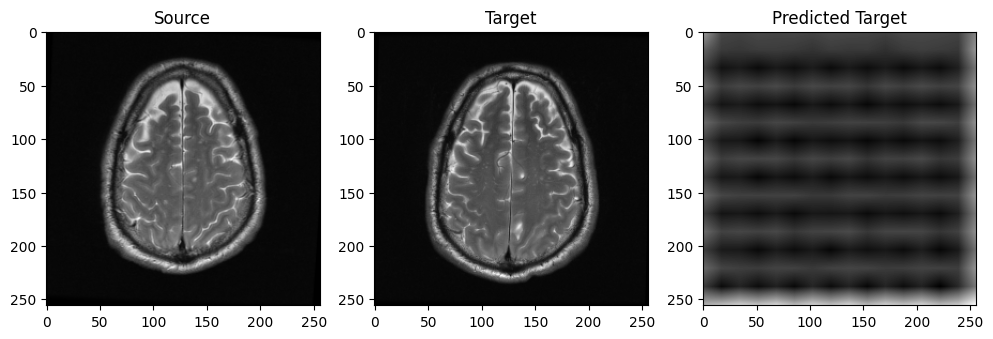

Epoch 1/10, Loss: 1.3942


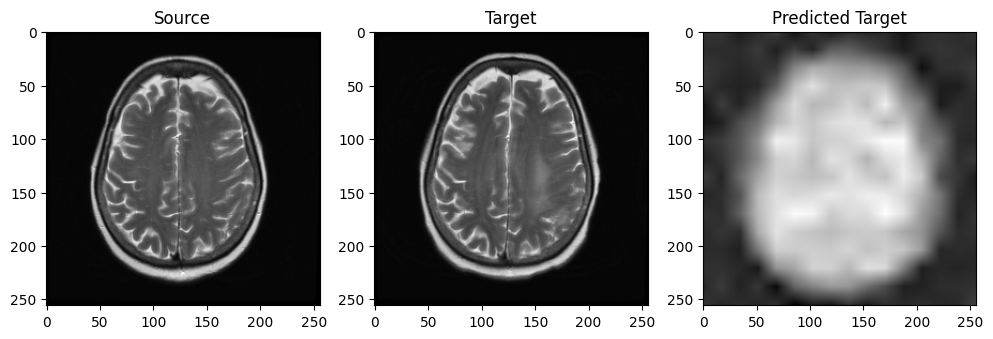

Epoch 2/10, Loss: 1.0627


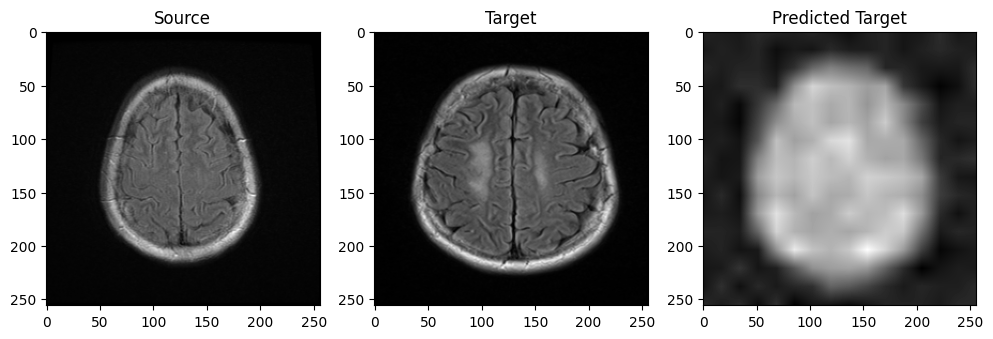

Epoch 3/10, Loss: 0.9868


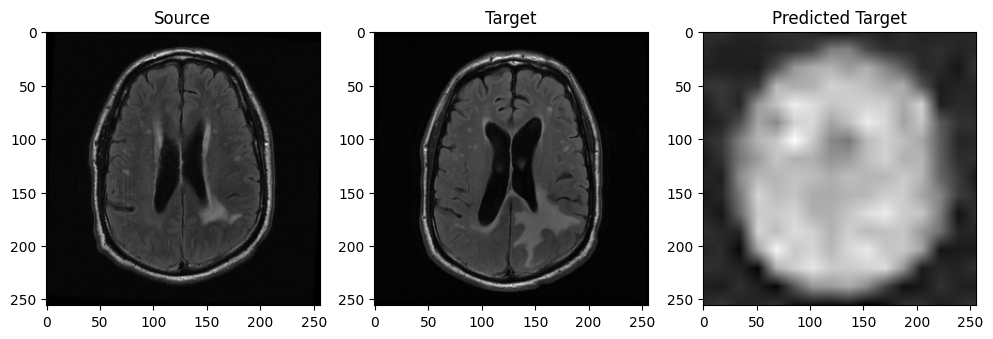

Epoch 4/10, Loss: 0.8991


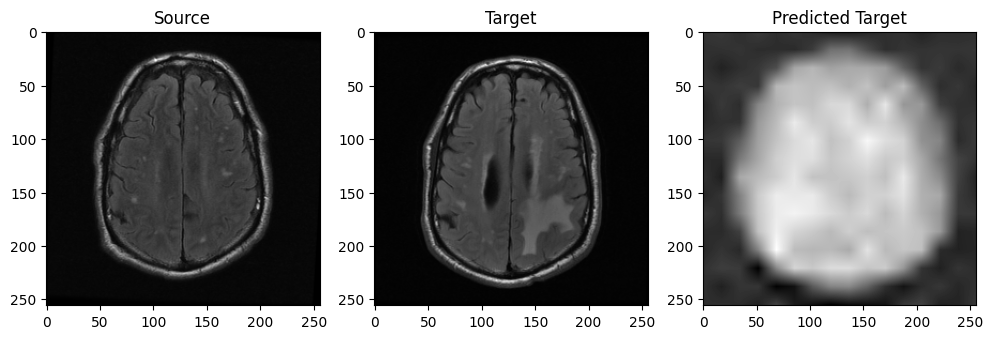

Epoch 5/10, Loss: 0.8571


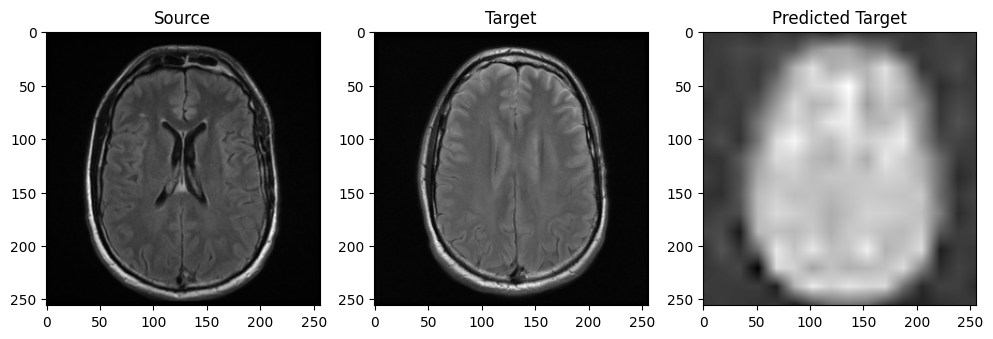

Epoch 6/10, Loss: 0.8052


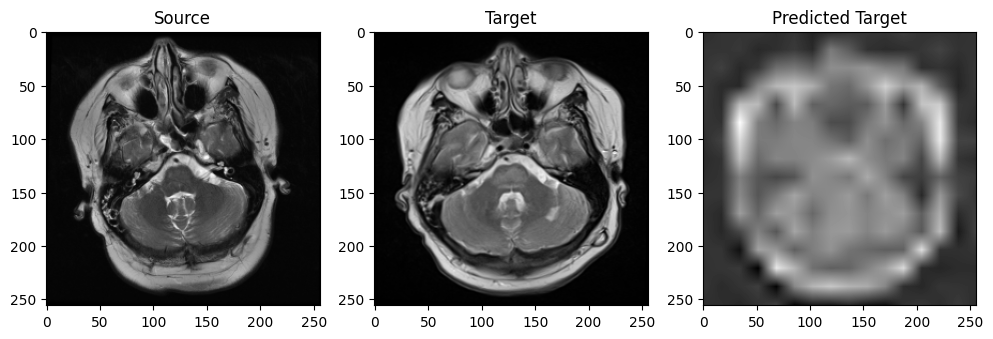

Epoch 7/10, Loss: 0.7670


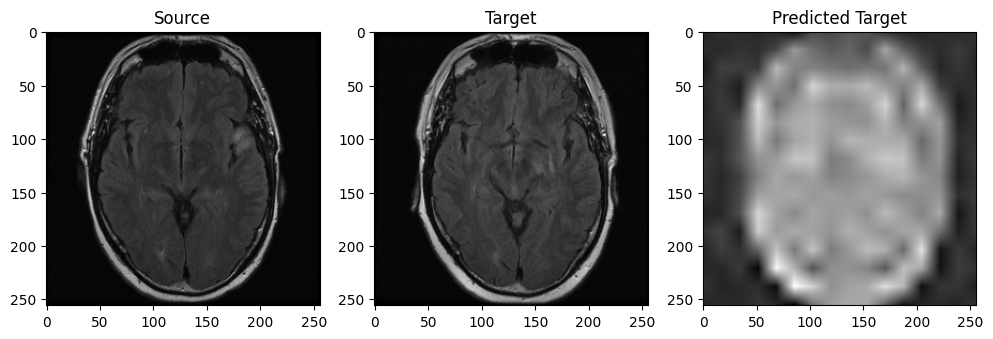

Epoch 8/10, Loss: 0.7591


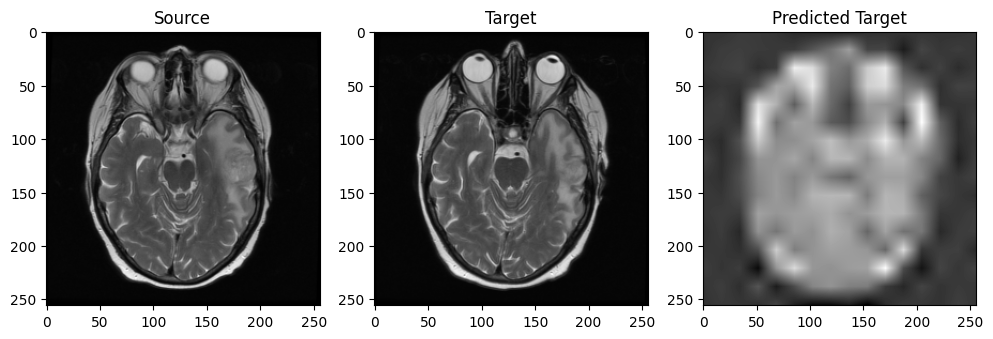

Epoch 9/10, Loss: 0.7293


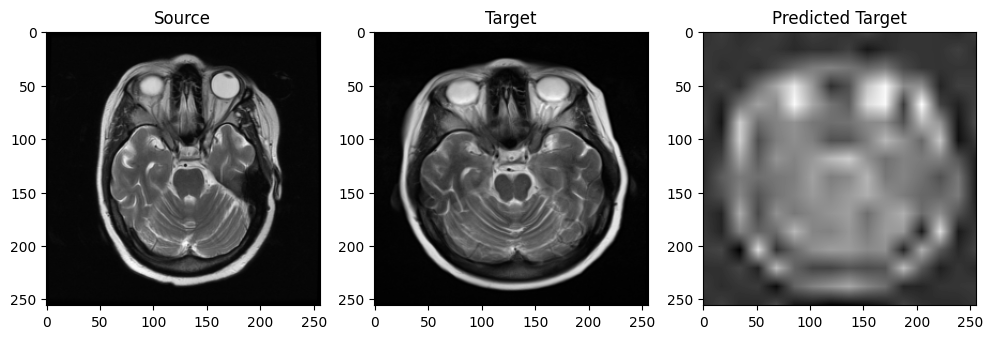

Epoch 10/10, Loss: 0.7095


In [ ]:
# Model initialization with EnhancedDecoder
encoder = Encoder(in_channel=1, channel=128, n_res_block=2, n_res_channel=32, stride=4).cuda()
decoder = EnhancedDecoder(in_channel=128, out_channel=1, channel=128, n_res_block=2, n_res_channel=32, stride=4).cuda()
dummy_input = torch.randn(1, 1, 256, 256).cuda()
flatten_dim = encoder(dummy_input).view(1, -1).size(1)
model = CCTEBMModel(encoder, decoder, input_dim=flatten_dim).cuda()

# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Start training with improved decoder
train_model_with_combined_loss(model, train_loader, optimizer, epochs=10, gamma=0.1)

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dataset definition
class GlioblastomaMRIDataset(Dataset):
    def __init__(self, pre_dir, post_dir):
        self.pre_dir = pre_dir
        self.post_dir = post_dir
        self.pre_files = sorted(os.listdir(pre_dir))
        self.post_files = sorted(os.listdir(post_dir))

    def __len__(self):
        return len(self.pre_files)

    def __getitem__(self, idx):
        pre_path = os.path.join(self.pre_dir, self.pre_files[idx])
        post_path = os.path.join(self.post_dir, self.post_files[idx])
        pre_dicom = pydicom.dcmread(pre_path)
        post_dicom = pydicom.dcmread(post_path)

        pre_image = pre_dicom.pixel_array.astype(np.float32)
        post_image = post_dicom.pixel_array.astype(np.float32)

        # Normalize pixel arrays
        if (pre_image.max() - pre_image.min()) > 0:
            pre_image = (pre_image - pre_image.min()) / (pre_image.max() - pre_image.min())
        else:
            pre_image = np.zeros_like(pre_image)

        if (post_image.max() - post_image.min()) > 0:
            post_image = (post_image - post_image.min()) / (post_image.max() - post_image.min())
        else:
            post_image = np.zeros_like(post_image)

        pre_image = cv2.resize(pre_image, (256, 256))
        post_image = cv2.resize(post_image, (256, 256))

        pre_image = torch.tensor(pre_image[None, :], dtype=torch.float32)
        post_image = torch.tensor(post_image[None, :], dtype=torch.float32)
        return pre_image, post_image

# VAE definition
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 64 * 64, latent_dim)
        self.fc_logvar = nn.Linear(128 * 64 * 64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 64 * 64),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        encoded = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder[0](z).view(-1, 128, 64, 64)
        return self.decoder[1:](z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

# EBM definition
class EBM(nn.Module):
    def __init__(self, latent_dim):
        super(EBM, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, z):
        return self.energy_net(z)

# Loss functions
def vae_loss(reconstructed, x, mu, logvar):
    recon_loss = nn.MSELoss()(reconstructed, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

def combined_loss(z_s2t, z_t2s, latent_source, latent_target, gamma=0.1):
    consistency_loss = nn.MSELoss()(latent_source, z_t2s) + nn.MSELoss()(latent_target, z_s2t)
    return gamma * consistency_loss

def visualize_results(source, target, predicted_target):
    source = source.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    predicted_target = predicted_target.cpu().detach().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Source")
    plt.imshow(source[0, 0], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Target")
    plt.imshow(target[0, 0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Target")
    plt.imshow(predicted_target[0, 0], cmap='gray')
    plt.show()

# Initialize weights
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

# Training loop
def train_cct_ebm(vae, ebm_s2t, ebm_t2s, dataloader, optimizer_vae, optimizer_ebm, epochs, latent_dim):
    vae.apply(init_weights)
    ebm_s2t.apply(init_weights)
    ebm_t2s.apply(init_weights)

    for epoch in range(epochs):
        vae.train()
        ebm_s2t.train()
        ebm_t2s.train()
        total_loss = 0

        for batch_idx, (source, target) in enumerate(dataloader):
            source, target = source.cuda(), target.cuda()
            optimizer_vae.zero_grad()
            optimizer_ebm.zero_grad()

            reconstructed, mu, logvar = vae(source)
            z_source = vae.reparameterize(mu, logvar)

            _, mu_target, logvar_target = vae(target)
            z_target = vae.reparameterize(mu_target, logvar_target)

            energy_s2t = ebm_s2t(z_source)
            energy_t2s = ebm_t2s(z_target)

            vae_recon_loss = vae_loss(reconstructed, source, mu, logvar)
            consistency = combined_loss(energy_s2t, energy_t2s, z_source, z_target)

            loss = vae_recon_loss + consistency
            loss.backward()

            optimizer_vae.step()
            optimizer_ebm.step()

            total_loss += loss.item()
            if batch_idx == 0:
                visualize_results(source, target, reconstructed)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss:.4f}")

# Data preparation
pre_dir = "/content/drive/MyDrive/tumorpred/data/train/pre"
post_dir = "/content/drive/MyDrive/tumorpred/data/train/post"
train_dataset = GlioblastomaMRIDataset(pre_dir, post_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model initialization
latent_dim = 128
vae = VAE(latent_dim).cuda()
ebm_s2t = EBM(latent_dim).cuda()
ebm_t2s = EBM(latent_dim).cuda()

# Optimizers
optimizer_vae = optim.Adam(vae.parameters(), lr=1e-4)
optimizer_ebm = optim.Adam(list(ebm_s2t.parameters()) + list(ebm_t2s.parameters()), lr=1e-4)

# Train the model
train_cct_ebm(vae, ebm_s2t, ebm_t2s, train_loader, optimizer_vae, optimizer_ebm, epochs=100, latent_dim=latent_dim)

In [ ]:
from skimage.metrics import structural_similarity as ssim
import math

# Evaluation functions
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0  # Images are normalized between 0 and 1
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def evaluate_model(model, dataloader, device):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_ssim = 0
    total_images = 0

    with torch.no_grad():
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)

            # Predict
            reconstructed, _, _ = model(source)

            # Convert tensors to numpy arrays for evaluation
            target_np = target.cpu().numpy()
            reconstructed_np = reconstructed.cpu().numpy()

            for i in range(len(target)):
                gt = target_np[i, 0]
                pred = reconstructed_np[i, 0]

                # Calculate metrics
                mse = np.mean((gt - pred) ** 2)
                psnr = calculate_psnr(gt, pred)
                ssim_value = ssim(gt, pred, data_range=pred.max() - pred.min())

                total_mse += mse
                total_psnr += psnr
                total_ssim += ssim_value
                total_images += 1

    avg_mse = total_mse / total_images
    avg_psnr = total_psnr / total_images
    avg_ssim = total_ssim / total_images

    print(f"Evaluation Results:")
    print(f"Mean Squared Error (MSE): {avg_mse:.4f}")
    print(f"Peak Signal-to-Noise Ratio (PSNR): {avg_psnr:.2f} dB")
    print(f"Structural Similarity Index Measure (SSIM): {avg_ssim:.4f}")

# Prepare test dataset and dataloader
test_pre_dir = "/content/drive/MyDrive/tumorpred/data/val/pre"
test_post_dir = "/content/drive/MyDrive/tumorpred/data/val/post"
test_dataset = GlioblastomaMRIDataset(test_pre_dir, test_post_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate the model
evaluate_model(vae, test_loader, device=torch.device("cuda"))

Evaluation Results:
Mean Squared Error (MSE): 0.0216
Peak Signal-to-Noise Ratio (PSNR): 16.87 dB
Structural Similarity Index Measure (SSIM): 0.2281


In [ ]:
import numpy as np
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load pre-trained InceptionV3 model
def load_inception_model():
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    return model

# Resize and preprocess images
def preprocess_images(images):
    images_resized = []
    for img in images:
        img_resized = tf.image.resize(img, (299, 299)).numpy()
        img_preprocessed = preprocess_input(img_resized)
        images_resized.append(img_preprocessed)
    return np.array(images_resized)

# Calculate FID
def calculate_fid(real_images, generated_images, model):
    # Preprocess images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Calculate feature embeddings
    real_features = model.predict(real_images)
    gen_features = model.predict(generated_images)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Calculate squared difference between means
    diff = mu_real - mu_gen
    diff_squared = np.sum(diff**2)

    # Calculate the trace of the product of covariance matrices
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff_squared + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

# Example usage
if __name__ == "__main__":
    # Load real and generated images (shape: [N, H, W, C])
    # Replace these with your real and generated image arrays
    real_images = np.random.rand(100, 256, 256, 3)
    generated_images = np.random.rand(100, 256, 256, 3)

    # Load InceptionV3 model
    inception_model = load_inception_model()

    # Calculate FID
    fid_value = calculate_fid(real_images, generated_images, inception_model)
    print(f"FID: {fid_value:.4f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
FID: 0.0233
